# IMPORT

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
tf.compat.v1.random.set_random_seed(412)

import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


# TVSI

## VNINDEX

### 2.1.1. DATA EXPLORATION

In [3]:
tvsi_fpt = pd.read_csv('/content/modeling_data/select3/tvsi_FPT_01052019_13062021.csv')
tvsi_fpt.head(5)

,Ngày,Mở cửa,Đóng cửa,Thay đổi,% Thay đổi,Khối lượng GD Khớp lệnh,Giá trị GD Khớp lệnh,Khối lượng GD Thỏa thuận,Giá trị GD Thoả thuận,Tổng khối lượng GD,Tổng giá trị GD
0,11/06/2021,81.5,83.5,1.6,1.95,2359600.0,1.963900e+11,80000.0,7.008000e+09,235960.0,2.033950e+11
1,10/06/2021,81.7,81.9,0.2,0.24,2214900.0,1.808300e+11,363656.0,3.178353e+10,221490.0,2.126113e+11
2,09/06/2021,80.6,81.7,0.9,1.11,3576100.0,2.877900e+11,26000.0,2.246400e+09,357610.0,2.900402e+11
3,08/06/2021,82.0,80.8,-1.9,-2.30,3486000.0,2.851200e+11,1400000.0,1.237600e+11,348600.0,4.088755e+11
4,07/06/2021,84.6,82.7,-2.0,-2.36,3711200.0,3.084000e+11,558600.0,5.060916e+10,371120.0,3.590059e+11


In [4]:
tvsi_fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ngày                      532 non-null    object 
 1   Mở cửa                    532 non-null    float64
 2   Đóng cửa                  532 non-null    float64
 3   Thay đổi                  532 non-null    float64
 4   % Thay đổi                532 non-null    float64
 5   Khối lượng GD Khớp lệnh   532 non-null    float64
 6   Giá trị GD Khớp lệnh      532 non-null    float64
 7   Khối lượng GD Thỏa thuận  532 non-null    float64
 8   Giá trị GD Thoả thuận     532 non-null    float64
 9   Tổng khối lượng GD        532 non-null    float64
 10  Tổng giá trị GD           532 non-null    float64
dtypes: float64(10), object(1)
memory usage: 45.8+ KB


In [5]:
tvsi_fpt.describe()

,Mở cửa,Đóng cửa,Thay đổi,% Thay đổi,Khối lượng GD Khớp lệnh,Giá trị GD Khớp lệnh,Khối lượng GD Thỏa thuận,Giá trị GD Thoả thuận,Tổng khối lượng GD,Tổng giá trị GD
count,532.000000,532.000000,532.000000,532.000000,5.320000e+02,5.320000e+02,5.320000e+02,5.320000e+02,5.320000e+02,5.320000e+02
mean,56.737876,56.815602,0.058459,0.113741,1.897378e+06,1.112100e+11,3.787679e+05,2.449307e+10,1.421642e+06,1.357030e+11
std,11.819099,11.867453,1.176694,1.927413,9.639199e+05,6.865625e+10,8.816200e+05,5.725091e+10,1.023599e+06,1.000211e+11
min,40.500000,40.400000,-10.800000,-11.030000,2.084900e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.599000e+04,0.000000e+00
25%,48.500000,48.537500,-0.400000,-0.702500,1.222115e+06,6.013000e+10,0.000000e+00,0.000000e+00,7.183500e+05,6.506540e+10
50%,53.550000,53.600000,0.100000,0.165000,1.665640e+06,9.227500e+10,4.740000e+04,2.700000e+09,1.281600e+06,1.021430e+11
75%,58.000000,58.100000,0.562500,1.052500,2.332568e+06,1.459125e+11,2.947000e+05,1.660744e+10,1.919940e+06,1.758755e+11
max,95.500000,97.900000,4.700000,7.000000,6.853810e+06,4.048000e+11,8.115332e+06,4.361434e+11,6.853810e+06,6.819857e+11


### 2.1.2. VISUALIZATION

In [6]:
# X, col_name, color
tvsi_fpt_X = list(tvsi_fpt.index.values)
tvsi_fpt_cols = list(tvsi_fpt.columns)
tvsi_fpt_colors = ['b','g','r','c','m','y','k','b','g','r']

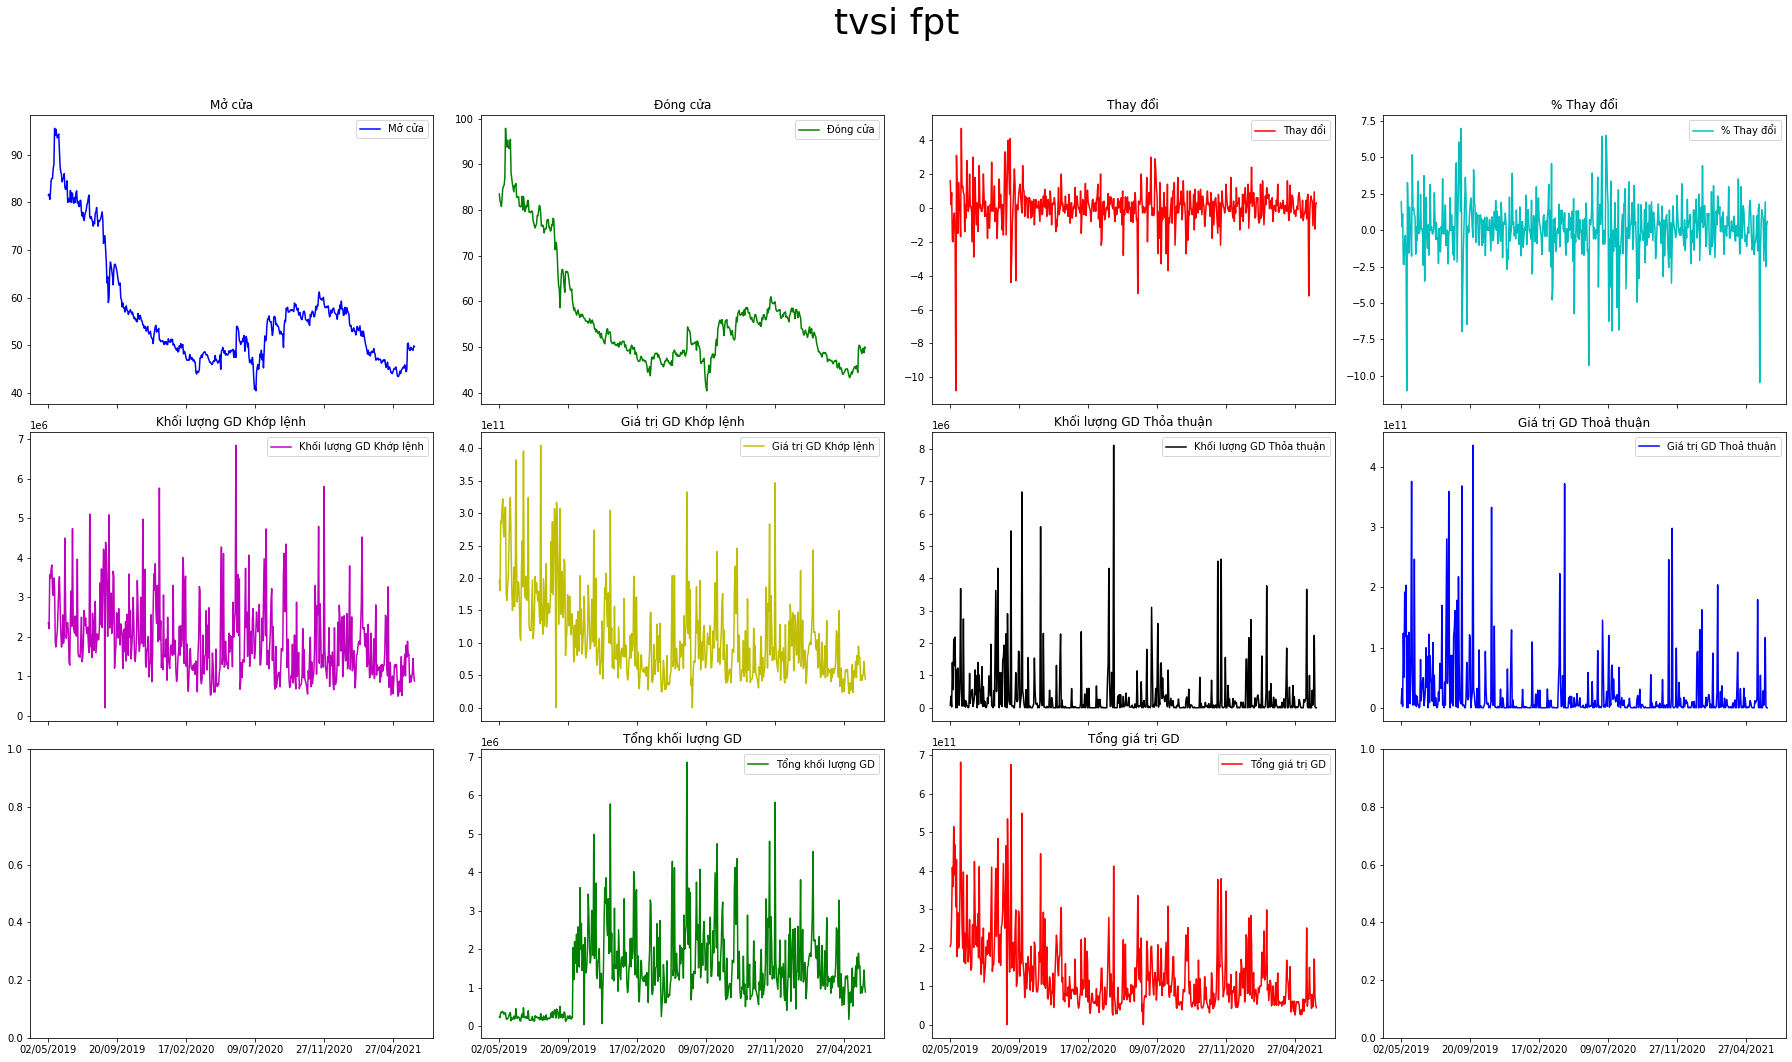

In [7]:
# plot
count = 0
fig, axs = plt.subplots(3, 4, sharex='col', figsize=(25,15))
tvsi_fpt_xticks = np.array([0, 100, 200, 300, 400, 500])
plt.setp(axs, xticks=tvsi_fpt_xticks,
         xticklabels=[tvsi_fpt[tvsi_fpt_cols[0]][i] for i in len(tvsi_fpt_X) - tvsi_fpt_xticks - 1])
for row in range(3):
    for col in range(4):
        if row < 2:
            count += 1
            axs[row, col].plot(tvsi_fpt_X, tvsi_fpt[tvsi_fpt_cols[count]],
                               label=tvsi_fpt_cols[count], color=tvsi_fpt_colors[count-1])
            axs[row, col].legend()
            axs[row, col].title.set_text(tvsi_fpt_cols[count])
        elif (col > 0) & (count < 10):
            count += 1
            axs[row, col].plot(tvsi_fpt_X, tvsi_fpt[tvsi_fpt_cols[count]],
                               label=tvsi_fpt_cols[count], color=tvsi_fpt_colors[count-1])
            axs[row, col].legend()
            axs[row, col].title.set_text(tvsi_fpt_cols[count])

fig.suptitle('tvsi fpt', fontsize=36)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

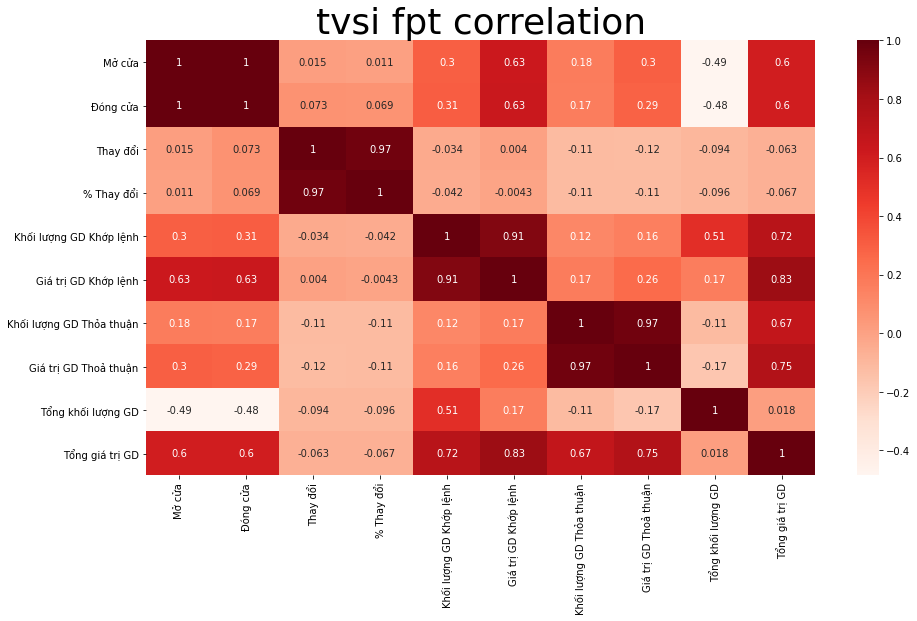

In [8]:
# correlation plot
plt.figure(figsize=(15,8))
tvsi_fpt_cor = tvsi_fpt.corr()
sns.heatmap(tvsi_fpt_cor, annot=True, cmap=plt.cm.Reds)
plt.title('tvsi fpt correlation', fontsize=36)
plt.show()

### 2.2.2. PREPROCESSING

In [9]:
# reverse data
reversed_tvsi_fpt = tvsi_fpt[::-1].reset_index(drop=True)
reversed_tvsi_fpt.head(5)

,Ngày,Mở cửa,Đóng cửa,Thay đổi,% Thay đổi,Khối lượng GD Khớp lệnh,Giá trị GD Khớp lệnh,Khối lượng GD Thỏa thuận,Giá trị GD Thoả thuận,Tổng khối lượng GD,Tổng giá trị GD
0,02/05/2019,49.8,49.85,0.30,0.61,885020.0,4.419000e+10,0.0,0.000000e+00,885020.0,4.418512e+10
1,03/05/2019,49.9,50.00,0.15,0.30,1059570.0,5.283000e+10,0.0,0.000000e+00,1059570.0,5.283412e+10
2,06/05/2019,49.0,48.75,-1.25,-2.50,1455140.0,7.114000e+10,40000.0,1.860000e+09,1455140.0,7.300209e+10
3,07/05/2019,49.1,49.70,0.95,1.95,1094880.0,5.403000e+10,2238940.0,1.165768e+11,1094880.0,1.706058e+11
4,08/05/2019,49.3,49.65,-0.05,-0.10,959020.0,4.743000e+10,530000.0,2.814300e+10,959020.0,7.557004e+10


In [10]:
# features
tvsi_fpt_features = np.array(reversed_tvsi_fpt[tvsi_fpt_cols[2]].astype('float32')).reshape(-1,1)

# MinMaxScaler
minmax = MinMaxScaler().fit(tvsi_fpt_features)
scaled_features = minmax.transform(tvsi_fpt_features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features

,0
0,0.164348
1,0.166956
2,0.145217
3,0.161739
4,0.160870
...,...
527,0.735652
528,0.702609
529,0.718261
530,0.721739


### 2.2.3. MODELING

In [11]:
# param
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 90
learning_rate = 0.01

# training df
df_train = scaled_features
df_train.shape

(532, 1)

In [12]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [13]:
# calculate_accuracy
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

# anchor
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [14]:
# train & predict
def train_predict(feature_df, data_df, test_size, cross_apply_flag=False, cross_apply_feature_df = [], cross_apply_data_df = []):
    tf.compat.v1.reset_default_graph()
    modelnn = Model(learning_rate, num_layers, scaled_features.shape[1], size_layer, scaled_features.shape[1], dropout_rate)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(data_df.iloc[:, 0]).tolist()

    # train
    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, feature_df.shape[0] - 1, timestamp):
            index = min(k + timestamp, feature_df.shape[0] - 1)
            batch_x = np.expand_dims(
                feature_df.iloc[k : index, :].values, axis = 0
            )
            batch_y = feature_df.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    # predict
    future_day = test_size

    output_predict = np.zeros((feature_df.shape[0] + future_day, feature_df.shape[1]))
    output_predict[0] = feature_df.iloc[0]
    upper_b = (feature_df.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (feature_df.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    feature_df.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != feature_df.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(feature_df.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : feature_df.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    prediction = anchor(output_predict[:, 0], 0.4)

    # cross apply
    if cross_apply_flag:
        date_ori = pd.to_datetime(cross_apply_data_df.iloc[:, 0]).tolist()

        output_predict = np.zeros((cross_apply_feature_df.shape[0] + future_day, cross_apply_feature_df.shape[1]))
        output_predict[0] = cross_apply_feature_df.iloc[0]
        upper_b = (cross_apply_feature_df.shape[0] // timestamp) * timestamp
        init_value = np.zeros((1, num_layers * 2 * size_layer))

        for k in range(0, (cross_apply_feature_df.shape[0] // timestamp) * timestamp, timestamp):
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(
                        cross_apply_feature_df.iloc[k : k + timestamp], axis = 0
                    ),
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            output_predict[k + 1 : k + timestamp + 1] = out_logits

        if upper_b != cross_apply_feature_df.shape[0]:
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(cross_apply_feature_df.iloc[upper_b:], axis = 0),
                    modelnn.hidden_layer: init_value,
                },
            )
            output_predict[upper_b + 1 : cross_apply_feature_df.shape[0] + 1] = out_logits
            future_day -= 1
            date_ori.append(date_ori[-1] + timedelta(days = 1))

        init_value = last_state
        
        for i in range(future_day):
            o = output_predict[-future_day - timestamp + i:-future_day + i]
            out_logits, last_state = sess.run(
                [modelnn.logits, modelnn.last_state],
                feed_dict = {
                    modelnn.X: np.expand_dims(o, axis = 0),
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            output_predict[-future_day + i] = out_logits[-1]
            date_ori.append(date_ori[-1] + timedelta(days = 1))
        
        output_predict = minmax.inverse_transform(output_predict)
        cross_apply_prediction = anchor(output_predict[:, 0], 0.4)

        return prediction, cross_apply_prediction
    
    return prediction

In [15]:
# train & predict for fpt
results = []
cross_apply_results = []
for i in range(5):
    print('simulation %d'%(i + 1))
    # predict
    prediction = train_predict(df_train, reversed_tvsi_fpt, test_size)
    results.append(prediction)

simulation 1
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/e

simulation 2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/e

simulation 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/e

simulation 4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/e

simulation 5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/e

In [16]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(tvsi_fpt_features)).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(tvsi_fpt_features) * 2).sum() == 0:
        accepted_results.append(r)
accuracies = [calculate_accuracy(tvsi_fpt_features, r[:-test_size]) for r in accepted_results]

date_ori = list(reversed_tvsi_fpt[tvsi_fpt_cols[0]])
last_day = datetime.strptime(date_ori[-1], '%d/%m/%Y')
weekday_range = range(5)
count = 0
while count < test_size:
    next_day = last_day + timedelta(days = 1)
    last_day = next_day
    if last_day.weekday() in weekday_range:
        date_ori.append(last_day.strftime(format='%d/%m/%Y'))
        count += 1

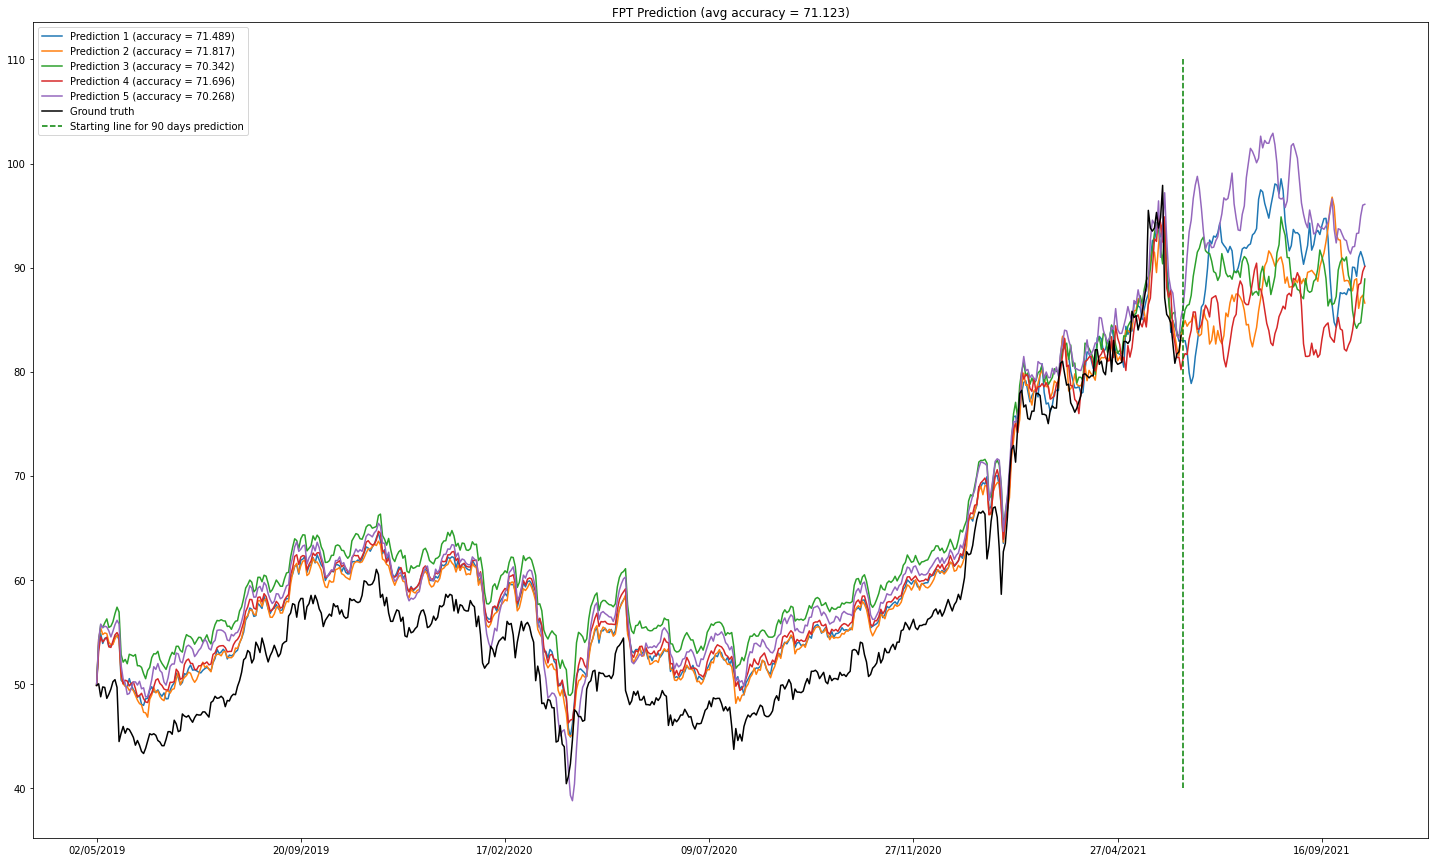

In [20]:
# plot
plt.figure(figsize = (25, 15))
for no, r in enumerate(accepted_results):
    plt.plot(r, label=f'Prediction {no + 1} (accuracy = {accuracies[no]:.3f})')
plt.plot(tvsi_fpt_features, label='Ground truth', c='k')
plt.plot([len(tvsi_fpt_features), len(tvsi_fpt_features)], [40, 110], '--g', label='Starting line for 90 days prediction')
plt.legend()
plt.title(f'FPT Prediction (avg accuracy = {np.mean(accuracies):.3f})')

x_range_future = np.arange(len(prediction))
plt.xticks(x_range_future[::100], date_ori[::100])
plt.show()